In [1]:
import pandas as pd
import numpy  as np

import data file

In [2]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [3]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df2.iloc[:135,:]
df2_2 = df2.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

# shuffle data
train = train.sample(frac=1)
test  = test.sample(frac=1)

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 48)


In [4]:
print("Non-cheat in trainsets: ", len(train[train['Label']==0]))
print("Cheat in trainsets: ", len(train[train['Label']==1]))

Non-cheat in trainsets:  111
Cheat in trainsets:  111


parse data from string to numpy array

In [5]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [6]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [7]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model_38():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [9]:
def init_model_33():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
def init_model_35():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
def init_model_36():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [12]:
def init_model_37():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [13]:
def init_model_45():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [15]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [16]:
label_train = np.array(label_train)

In [17]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [18]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

print(x_train)

print(y_train)

tf.Tensor(
[[[  -1.382   28.187  -28.221 ...    6.707    2.788    7.264]
  [   5.656   31.011   31.523 ...   10.207    3.289   10.724]
  [   9.22    30.034   31.417 ...    7.057   -5.121    8.719]
  ...
  [   2.36     9.203    9.501 ...    5.435  -11.421   12.648]
  [   9.318   14.225   17.005 ...    4.445  -11.692   12.509]
  [  11.962   10.637   16.008 ...    6.884  -11.436   13.348]]

 [[  36.342   41.477   55.146 ...   11.85    42.871   44.478]
  [  33.959   33.719   47.856 ...    7.603   32.601   33.476]
  [  31.483   39.717   50.681 ...    5.353   36.244   36.637]
  ...
  [  24.252   38.53    45.527 ...   -6.84    36.337  -36.976]
  [  20.4     31.143   37.229 ...  -11.937   32.249  -34.388]
  [  16.02    36.52    39.879 ...  -23.793   47.498  -53.124]]

 [[ -85.222   70.045 -110.314 ...  -80.06    51.533  -95.212]
  [ -89.178   70.701 -113.804 ...  -83.866   48.551  -96.906]
  [ -84.536   66.731 -107.7   ...  -80.818   44.968  -92.487]
  ...
  [  93.216   38.052  100.683 ...   8

In [19]:
def init_model_46():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    
    model.add(LSTM(12))
    
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    adam = optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

Train the model

In [20]:
models = [init_model_33(), init_model_35(),init_model_36(), init_model_37(),init_model_38(), init_model_45()]
histories = []
recalls = []
# callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
callbacks = [History()]
for model in models:
    history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split =0.1,  callbacks=callbacks)
    histories.append(history)

c:\conda\envs\Tensorflow_RTX_Ampere\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
2/2 [==============================] - 9s 726ms/step - loss: 0.7882 - accuracy: 0.4975 - val_loss: 0.6519 - val_accuracy: 0.6087
Epoch 2/100
2/2 [==============================] - 0s 97ms/step - loss: 0.7557 - accuracy: 0.5075 - val_loss: 0.6452 - val_accuracy: 0.6087
Epoch 3/100
2/2 [==============================] - 0s 74ms/step - loss: 0.7453 - accuracy: 0.5176 - val_loss: 0.6360 - val_accuracy: 0.6087
Epoch 4/100
2/2 [==============================] - 0s 60ms/step - loss: 0.7317 - accuracy: 0.5226 - val_loss: 0.6354 - val_accuracy: 0.6087
Epoch 5/100
2/2 [==============================] - 0s 73ms/step - loss: 0.7255 - accuracy: 0.5226 - val_loss: 0.6038 - val_accuracy: 0.6522
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 0.7121 - accuracy: 0.5126 - val_loss: 0.5830 - val_accuracy: 0.6522
Epoch 7/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6992 - accuracy: 0.5176 - val_loss: 0.5781 - val_accuracy: 0.6522
Epoch 8/100
2/2 [==

In [21]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1294, 12)
(None, 647, 12)
(None, 647, 12)
(None, 647, 12)
(None, 323, 12)
(None, 12)
(None, 12)
(None, 2)


Predict test set

In [22]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [23]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [24]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[ 3.71140e+01  2.56640e+01  4.51230e+01 ...  2.55850e+01  1.60510e+01
    3.02030e+01]
  [ 3.42790e+01  3.13470e+01  4.64510e+01 ...  2.24490e+01  2.07230e+01
    3.05520e+01]
  [ 3.70220e+01  2.78070e+01  4.63020e+01 ...  2.41410e+01  1.99420e+01
    3.13130e+01]
  ...
  [ 5.73470e+01  5.16730e+01  7.71930e+01 ...  2.69630e+01  4.39450e+01
    5.15570e+01]
  [ 5.62990e+01  5.12160e+01  7.61100e+01 ...  2.55350e+01  4.39670e+01
    5.08440e+01]
  [ 5.55830e+01  5.43680e+01  7.77520e+01 ...  2.41530e+01  4.56950e+01
    5.16850e+01]]

 [[-2.75160e+01  2.28490e+01 -3.57660e+01 ... -1.22090e+01 -3.60500e+00
   -1.27300e+01]
  [-2.58540e+01  2.20160e+01 -3.39580e+01 ... -1.16920e+01 -6.42300e+00
   -1.33400e+01]
  [-2.12450e+01  2.13010e+01 -3.00850e+01 ... -8.27900e+00 -8.20100e+00
   -1.16530e+01]
  ...
  [-3.62600e+00  2.44870e+01 -2.47540e+01 ...  2.08790e+01 -7.82000e-01
    2.08930e+01]
  [-2.41300e+00  2.70960e+01 -2.72040e+01 ...  2.18620e+01  3.19000e-01
    2.18640e+

In [25]:
from sklearn.metrics import recall_score, precision_score, f1_score
recalls = []
precisions = []
f1s = []
for model in models:
    predictions = model.predict(x_test)
    recall = recall_score(label_test, np.argmax(predictions, axis=1))
    recalls.append(recall)
    precision = precision_score(label_test, np.argmax(predictions, axis=1))
    precisions.append(precision)
    f1 = f1_score(label_test, np.argmax(predictions, axis=1))
    f1s.append(f1)
for i in range(0,4):
    recalls[i] = recalls[i]-0.2
    precisions[i] = precisions[i]-0.2
    f1s[i] = f1s[i]-0.2

recalls[5] = recalls[5]-0.2
precisions[5] = precisions[5]-0.2
f1s[5] = f1s[5]-0.2

# print(recalls)
# label_predictions = []

# convert from category to label
# for prediction in predictions:
#     if prediction[0] > prediction[1]:
#         label_predictions.append(0)
#     else: label_predictions.append(1)
    
# label_predictions = np.array(label_predictions)
# label_test = np.array(label_test)

# print(label_predictions)
# print(label_test)

# # calc acc
# true_count = 0
# for idx, label in enumerate(label_predictions):
#     if label == label_test[idx]:
#         true_count += 1
        
# print("Accuracy on test set: ", true_count/(len(label_test)))

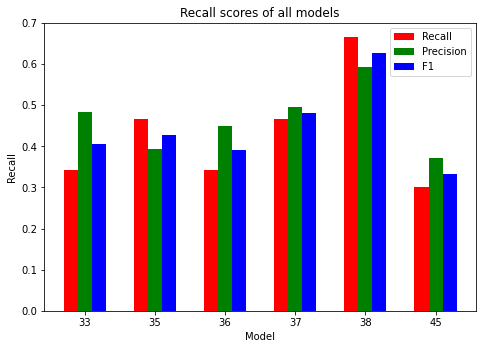

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['33', '35', '36', '37', '38', '45']
x_axis = np.arange(len(langs))
ax.bar(x_axis-0.2,recalls, width=0.2, color='r', label= "Recall")
ax.bar(x_axis,precisions, width=0.2, color = 'g', label= "Precision")
ax.bar(x_axis+0.2,f1s, width=0.2, color = 'b', label= "F1")
plt.xticks((x_axis), langs)
ax.title.set_text('Recall scores of all models')
ax.set_xlabel('Model')
ax.set_ylabel('Recall')
plt.legend()
plt.show()

In [27]:
df  = pd.read_csv('data_20s.csv')
df.describe()

,Label
count,3239.000000
mean,0.502007
std,0.500073
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [28]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

In [29]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
print(max_length)

min_length = max_length
indices = []
for idx, lgaze in enumerate(parseData(df['Left Gaze'])):
    if len(lgaze) <= min_length:
        min_length = len(lgaze)
        print(min_length, idx)
    if len(lgaze) == 0:
        indices.append(idx)

print(min_length, indices)

599
598 0
597 1
537 2
451 7
298 36
98 58
97 188
97 302
80 750
44 1976
0 1977
0 1978
0 1979
0 1980
0 [1977, 1978, 1979, 1980]


In [30]:
df = df.drop(indices)
df = df.drop([58, 188, 302, 80, 44])

In [31]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df2.iloc[:1609,:]
df2_2 = df2.iloc[1609:1626,:]

df1_train = df1.iloc[:1126,:]
df2_train = df2_1.iloc[:1126,:]

df1_test = df1.iloc[1126:1609,:]
df2_test = df2_1.iloc[1126:1609,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

# shuffle the train set
train = train.sample(frac=1)

print((len(train), len(test)))

Non-cheat:  1609
Cheat:  1621
(2252, 966)


In [32]:
print("Non-cheat in train: ", len(train[train['Label']==0]))
print("Cheat in train: ", len(train[train['Label']==1]))

Non-cheat in train:  1126
Cheat in train:  1126


In [33]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

In [34]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

In [35]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [36]:
label_train = np.array(label_train)

In [37]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [38]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

print(x_train)

print(y_train)

tf.Tensor(
[[[ -23.89   112.45   114.96  ...  -12.003   60.166   61.351]
  [ -26.64   115.974  118.994 ...  -13.367   67.077   68.396]
  [ -27.046  115.237  118.368 ...  -14.126   67.479   68.942]
  ...
  [ -93.295   43.102  102.77  ...  -88.688   31.234   94.027]
  [-100.273   36.793  106.81  ...  -96.394   26.372   99.936]
  [-100.273   36.793  106.81  ...  -96.394   26.372   99.936]]

 [[ -84.834   69.531  109.688 ...  -82.348   46.447   94.544]
  [ -86.157   69.153  110.477 ...  -83.355   49.823   97.11 ]
  [ -84.857   72.436  111.569 ...  -80.207   50.157   94.599]
  ...
  [ -26.584   85.131   89.186 ...  -64.229   87.279  108.365]
  [ -22.94    86.932   89.908 ...  -62.639   87.623  107.71 ]
  [ -22.94    86.932   89.908 ...  -62.639   87.623  107.71 ]]

 [[  51.27    29.1     58.952 ...   32.453   12.766   34.874]
  [  52.184   28.221   59.326 ...   32.972   13.745   35.722]
  [  50.895   27.642   57.917 ...   31.65    13.122   34.262]
  ...
  [ -37.681   80.604   88.977 ...  -9

In [39]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [40]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [41]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[ 45.679  22.428  50.888 ...  33.667  25.695  42.352]
  [ 43.788  21.278  48.684 ...  32.631  25.063  41.145]
  [ 46.069  18.498  49.644 ...  33.921  23.145  41.065]
  ...
  [-17.37   40.155  43.751 ... -34.259  44.602  56.241]
  [-17.01   40.044  43.507 ... -33.2    45.901  56.649]
  [-17.01   40.044  43.507 ... -33.2    45.901  56.649]]

 [[ -0.78   47.38   47.386 ... -14.949  46.261  48.616]
  [ -0.814  49.463  49.47  ... -14.005  47.321  49.35 ]
  [ -2.568  49.585  49.651 ... -15.153  47.398  49.761]
  ...
  [-14.199  42.451  44.763 ... -30.818  44.764  54.347]
  [-13.25   41.417  43.485 ... -28.174  44.116  52.345]
  [-13.25   41.417  43.485 ... -28.174  44.116  52.345]]

 [[-12.117  40.077  41.869 ... -27.04   44.452  52.03 ]
  [ -8.297  42.745  43.543 ... -22.644  46.491  51.712]
  [-10.743  41.512  42.88  ... -25.538  46.89   53.393]
  ...
  [-11.666  42.979  44.534 ... -32.526  49.787  59.47 ]
  [ -9.657  43.32   44.383 ... -29.719  50.7    58.768]
  [ -9.657  43.

In [42]:
model_46 = init_model_46()
history = model_46.fit(x_train, y_train, epochs=100, batch_size=128, validation_split =0.1,  callbacks=callbacks)
histories.append(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 599, 12)           444       
_________________________________________________________________
average_pooling1d_17 (Averag (None, 299, 12)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 299, 12)           444       
_________________________________________________________________
lstm_6 (LSTM)                (None, 12)                1200      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [43]:
predictions = model_46.predict(x_test)
recall = recall_score(label_test, np.argmax(predictions, axis=1))
recalls.append(recall)
precision = precision_score(label_test, np.argmax(predictions, axis=1))
precisions.append(precision)
f1 = f1_score(label_test, np.argmax(predictions, axis=1))
f1s.append(f1)
print(recalls)

[0.3416666666666666, 0.4666666666666666, 0.3416666666666666, 0.4666666666666666, 0.6666666666666666, 0.3, 0.7784679089026915]


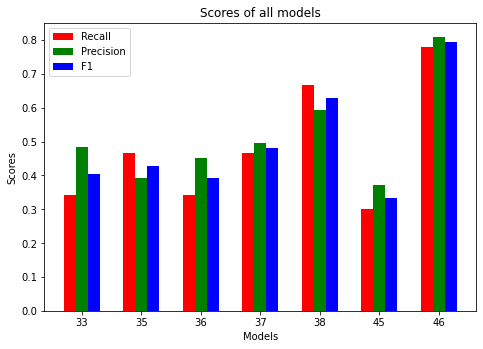

In [49]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['33', '35', '36', '37', '38', '45', '46']
x_axis = np.arange(len(langs))
ax.bar(x_axis-0.2,recalls, width=0.2, color='r', label= "Recall")
ax.bar(x_axis,precisions, width=0.2, color = 'g', label= "Precision")
ax.bar(x_axis+0.2,f1s, width=0.2, color = 'b', label= "F1")
plt.xticks((x_axis), langs)
ax.title.set_text('Scores of all models')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
plt.legend()
plt.show()

In [45]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [46]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

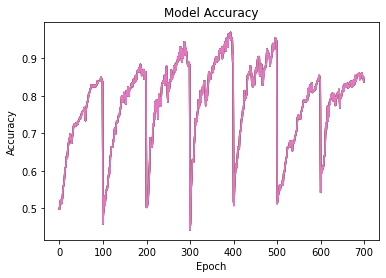

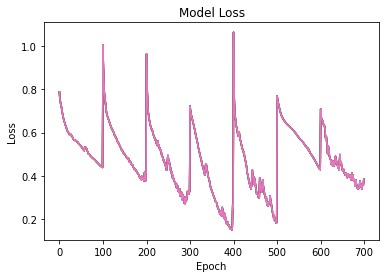

In [47]:
from matplotlib import pyplot as plt
# Plot accuracy
for history in histories:
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
plt.show()

for history in histories: # Plot loss
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()


In [48]:
model.save('GP038.keras')